In [1]:
import boto3 #Amazon AWS Python SDK
from botocore.config import Config #Config for SDK
from dotenv import load_dotenv # Load .ENV file containing protected information
import os # Ability to manage and access neigboring files 
from io import BytesIO
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Make the environment variables available to python from the .env file
load_dotenv()
# Load the environment variables into python variables
ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
POLYGON_KEY = os.getenv("POLYGON_API_KEYS")

In [3]:
# Initialize a session using the AWS keys
session = boto3.Session( # Session object used to configure users and environment control
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
)

In [4]:
# Create a client with session and speficy the endpoint (where the data is located)
s3 = session.client(
    's3', # Connecting to the S3 (Simple Storage Service) specifically (can connect to any aws service here)
    endpoint_url='https://files.polygon.io', # Base url for the service you want to access
    config=Config(signature_version='s3v4'), # Ensures client is using AWS signature Version 4 protocol by prohibiting api requests unless supplied with
                                             # a secret key. Used for hashsing
)
# The previous code is everything needed to accesss the S3 flatfiles, from here you can use commands like list objects or get objects

In [5]:
# Initialize a paginator for listing objects
paginator = s3.get_paginator('list_objects_v2')

In [6]:
# Choose the appropriate prefix depending on the data you need:
# - 'global_crypto' for global cryptocurrency data
# - 'global_forex' for global forex data
# - 'us_indices' for US indices data
# - 'us_options_opra' for US options (OPRA) data
# - 'us_stocks_sip' for US stocks (SIP) data
def get_daily_polygon_files(start_year, years):
    """
    returns all the s3 files to download

    Args:
        start_year (int): Year to start historical data pull.
        years (int): Amount of years to pull files for.

    Returns:
        object_keys: A list of files that will be pulled from S3.
    """
    #One liner to make the list of years to pull from. Paginator will recursively get all the files from s3
    prefixes = [f'us_stocks_sip/day_aggs_v1/{year}' for year in range(start_year, start_year + years)]
    # List objects using the selected prefix
    object_keys = []
    for prefix in prefixes:
        for page in paginator.paginate(Bucket='flatfiles', Prefix=prefix):
            for obj in page['Contents']:
                object_keys.append(obj['Key'])
    return object_keys

In [7]:
def get_daily_data(keys):
    """
    grabs all the csv files stored in keys, unzips them, and concatenates them all in a dataframe


    Args:
        keys (String[]): list of csv file paths to download from s3

    Returns:
        Dataframe: dataframe with stock data appended from all days
    """
    dfs = []
    for key in tqdm(keys, desc="Fetching Stock data"):
        if key.endswith('csv.gz'):
            response = s3.get_object(Bucket='flatfiles', Key=key)
            df = pd.read_csv(BytesIO(response['Body'].read()), compression = 'gzip')
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)            

In [8]:
data = get_daily_data(get_daily_polygon_files(2021, 5))

Fetching Stock data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1069/1069 [01:27<00:00, 12.23it/s]


In [9]:
def data_evaluation(data):
    """
    evaluates the data and prints null values and missing data

    Args:
        data: input data frame

    Returns:
        Void
    """
    ticker_counts = data['ticker'].value_counts()
    most_common_value = ticker_counts.mode().iloc[0]
    num_incomplete_tickers = int((ticker_counts != most_common_value).sum())
    incomplete_percentage = (num_incomplete_tickers / ticker_counts.size) * 100
    
    print(f"""
Amount of null values per column: \n {data.isnull().sum()} \n
Number of unique tickers: {data['ticker'].nunique()}
The mode of the amount of tickers is {most_common_value}
The number of incomplete tickers is {num_incomplete_tickers}
The percentage of incomplete tickers relative to the mode is {incomplete_percentage:.3f}%
    """)

In [10]:
data_evaluation(data)


Amount of null values per column: 
 ticker          684
volume            0
open              0
close             0
high              0
low               0
window_start      0
transactions      0
dtype: int64 

Number of unique tickers: 17970
The mode of the amount of tickers is 1069
The number of incomplete tickers is 12418
The percentage of incomplete tickers relative to the mode is 69.104%
    


In [11]:
#import numpy as np
#Example inject null values for testing
#data.loc[0, 'volume'] = np.nan

In [12]:
def get_clean_tickers(data):
    
    #Remove null tickers from ticker list
    unique_tickers = data['ticker'].dropna().unique()
    tickers_with_null = data[data.isnull().any(axis=1)]['ticker'].dropna().unique().tolist()
    valid_tickers = list(set(unique_tickers) - set(tickers_with_null))

    #Create new filtered DataFrame and filter further based on mode amount of samples
    filtered_null_data = data[data['ticker'].isin(valid_tickers)]
    ticker_counts = filtered_null_data['ticker'].value_counts()
    most_common_value = ticker_counts.mode().iloc[0]
    # Get tickers that don't have the mode number of rows
    incomplete_tickers = ticker_counts[ticker_counts != most_common_value].index.tolist()
    filtered_final_data = filtered_null_data[filtered_null_data['ticker'].isin(list(set(valid_tickers) - set(incomplete_tickers)))]

    #Print null tickers, evaulate final data, and return final df
    print(f"tickers with null: {tickers_with_null}")
    data_evaluation(filtered_final_data)
    filtered_final_data = filtered_final_data.copy()
    filtered_final_data['time'] = pd.to_datetime(filtered_final_data['window_start']).dt.date
    filtered_final_data.drop(columns=['window_start'])
    return filtered_final_data

In [13]:
filtered_data = get_clean_tickers(data)

tickers with null: []

Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
window_start    0
transactions    0
dtype: int64 

Number of unique tickers: 5552
The mode of the amount of tickers is 1069
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


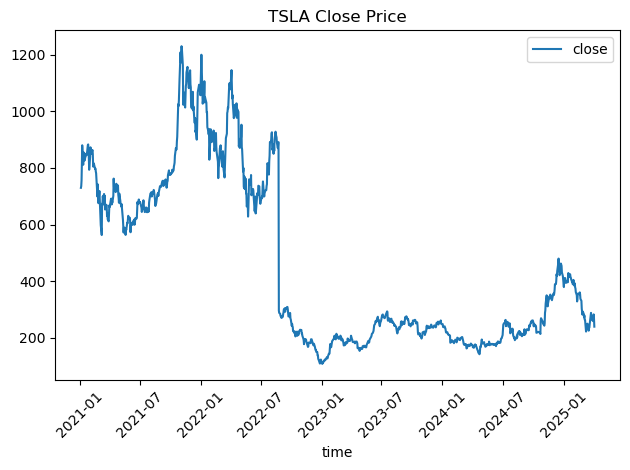

In [14]:
filtered_data[filtered_data['ticker'] == 'TSLA'].plot(x='time', y='close', title='TSLA Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels vertically
plt.tight_layout()       # Optional: prevent clipping
plt.show()

In [15]:
from polygon import RESTClient

client = RESTClient(POLYGON_KEY)

splits = []
for s in client.list_splits(
	order="asc",
	limit="10",
	sort="execution_date",
	):
    splits.append(s)

In [16]:
data

,ticker,volume,open,close,high,low,window_start,transactions
0,A,1980148,118.940,118.6400,120.09,117.1100,1609736400000000000,21357
1,AA,5400045,23.620,23.2500,24.45,23.1250,1609736400000000000,30118
2,AAA,3722,25.065,25.0654,25.07,25.0650,1609736400000000000,20
3,AAAU,767803,19.330,19.3500,19.36,19.2243,1609736400000000000,1190
4,AACG,17972,1.170,1.1800,1.22,1.1700,1609736400000000000,111
...,...,...,...,...,...,...,...,...
11443203,ZXZZT,10240,12.100,12.1000,12.10,12.1000,1743739200000000000,225
11443204,ZYBT,288978,4.650,4.2900,4.83,4.0900,1743739200000000000,1012
11443205,ZYME,1241592,11.400,10.9500,11.75,10.6100,1743739200000000000,12715
11443206,ZYXI,332473,2.200,2.1600,2.24,2.1000,1743739200000000000,2681


In [17]:
def adjust_for_splits(data, splits):
    start_date = pd.to_datetime(data['time'].min())
    end_date = pd.to_datetime(data['time'].max())

    tickers_in_data = set(data['ticker'].unique())

    # Filter splits
    filtered = [
        s for s in splits
        if start_date <= pd.to_datetime(s.execution_date) <= end_date
        and s.ticker in tickers_in_data
    ]

    data = data.copy()
    splits = sorted(filtered, key=lambda s: s.execution_date)

    for split in tqdm(splits, desc='Adjusting ohlcv data to splits'):
        exec_date = pd.to_datetime(split.execution_date)
        ratio = split.split_from / split.split_to
        ticker = split.ticker

        # Use the 'time' column for the date filter
        mask = (data['ticker'] == ticker) & (pd.to_datetime(data['time']) < exec_date)
        data.loc[mask, ['open', 'high', 'low', 'close']] *= ratio
        data.loc[mask, 'volume'] /= ratio

    return data


In [18]:
data = adjust_for_splits(filtered_data, splits)

/tmp/ipykernel_78255/2432450480.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[167208.45 134751.3  227146.4  161302.55 117286.15]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[mask, 'volume'] /= ratio
Adjusting ohlcv data to splits: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 765/765 [06:22<00:00,  2.00it/s]


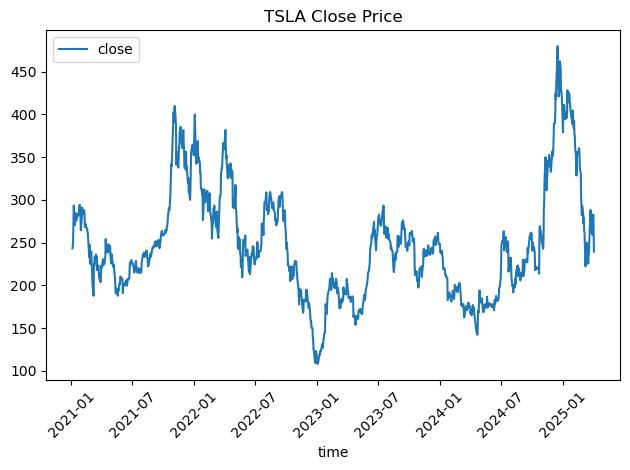

In [19]:
data[data['ticker'] == 'TSLA'].plot(x='time', y='close', title='TSLA Close Price')
plt.xticks(rotation=45)  # Rotate x-axis labels vertically
plt.tight_layout()       # Optional: prevent clipping
plt.show()

In [20]:
data_evaluation(data)


Amount of null values per column: 
 ticker          0
volume          0
open            0
close           0
high            0
low             0
window_start    0
transactions    0
time            0
dtype: int64 

Number of unique tickers: 5552
The mode of the amount of tickers is 1069
The number of incomplete tickers is 0
The percentage of incomplete tickers relative to the mode is 0.000%
    


In [21]:
data

,ticker,volume,open,close,high,low,window_start,transactions,time
0,A,1980148.0,118.940,118.6400,120.09,117.1100,1609736400000000000,21357,2021-01-04
1,AA,5400045.0,23.620,23.2500,24.45,23.1250,1609736400000000000,30118,2021-01-04
2,AAA,3722.0,25.065,25.0654,25.07,25.0650,1609736400000000000,20,2021-01-04
3,AAAU,767803.0,19.330,19.3500,19.36,19.2243,1609736400000000000,1190,2021-01-04
12,AAL,69422902.0,15.850,15.1300,15.88,15.0300,1609736400000000000,238597,2021-01-04
...,...,...,...,...,...,...,...,...,...
11443192,ZTST,0.0,40.170,40.1700,40.17,40.1700,1743739200000000000,0,2025-04-04
11443194,ZUMZ,805169.0,13.130,13.1100,14.07,12.9250,1743739200000000000,12541,2025-04-04
11443202,ZXIET,2000.0,100.000,100.0000,100.00,100.0000,1743739200000000000,1,2025-04-04
11443205,ZYME,1241592.0,11.400,10.9500,11.75,10.6100,1743739200000000000,12715,2025-04-04


In [22]:
db_user = os.getenv("POSTGRES_USER")
db_password = os.getenv("POSTGRES_PASSWORD")
db_host = os.getenv("POSTGRES_HOST")
db_port = os.getenv("POSTGRES_PORT")
db_name = os.getenv("POSTGRES_DB")

In [23]:
from sqlalchemy import create_engine

engine = create_engine(
    f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
)

In [24]:
data = data.drop(columns='window_start')

In [25]:
data.to_sql("ohlcv_data", engine, if_exists="append", index=False)

88